In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 10 - Modified CNN with Fibonacci

### v0 with second input of median and stdev

by Louis Yang

Use Fibonacci series median instead of median. The Fib. median are now compute on both training and CV set separately.

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained CNN as prediction.

Test on stage 2 data.

Original model: 'model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3'

Ensemble: automatically evaluate the same model 4 times

In [2]:
model_name = 'model_10_Modified_CNN_0_median_stdev'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [4]:
train_file = 'train_2.csv'

In [5]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file)
print('done!')

%%% Reading data train_2.csv ... done!


input_df.head()

input_df.info()

In [6]:
input_df_dates = input_df.columns[1:]; #input_df_dates

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [7]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [8]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [9]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [10]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [11]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2016-04-29', '2016-06-30')

daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

In [12]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [13]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2017-04-28', '2017-06-29')

daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

weekday(X_input_first_day), weekday(X_output_first_day)

Both are Wednesday (2).

#### Y

In [14]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [15]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-07-01', '2016-09-01')

daydiff(Y_input_first_day, Y_input_final_day)

In [16]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [17]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-06-30', '2017-08-31')

daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

weekday(Y_input_first_day), weekday(Y_output_first_day)

Both are Sunday (6).

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [18]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [19]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11',
        '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
        ...
        '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24', '2016-06-25',
        '2016-06-26', '2016-06-27', '2016-06-28', '2016-06-29', '2016-06-30'],
       dtype='object', length=329),
 Index(['2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
        '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
        ...
        '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
        '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29'],
       dtype='object', length=329))

In [20]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(4, 4)

In [21]:
fib_output_data = input_df[fib_output_dates].values; fib_output_data

array([[  49.,   10.,   19., ...,   32.,   34.,   21.],
       [  30.,   16.,   54., ...,  127.,  104.,   20.],
       [   7.,    2.,    1., ...,    5.,    5.,    0.],
       ..., 
       [  nan,   nan,   nan, ...,   35.,   46.,   43.],
       [  nan,   nan,   nan, ...,    6.,    6.,    7.],
       [  nan,   nan,   nan, ...,   21.,   20.,   14.]])

In [22]:
fib_input_data = input_df[fib_input_dates].values; fib_input_data

array([[  4.,  11.,  10., ...,  18.,  23.,  12.],
       [  2.,  23.,  12., ...,  24.,  16.,  15.],
       [  5.,   1.,   4., ...,   5.,   1.,   4.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

#### Fibonacci median in each window

In [23]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [24]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [25]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [26]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [27]:
fib_input_median

array([ 16.5 ,  15.25,   4.  , ...,   0.  ,   0.  ,   0.  ])

In [28]:
fib_output_median

array([ 24.  ,  22.5 ,   4.  , ...,  34.  ,   7.75,  11.25])

We will use this as the center and part of the result

In [29]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

input_data contains X_input and Y_input array

In [30]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates, X_input_first_day, Y_input_final_day

(Index(['2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02', '2016-05-03',
        '2016-05-04', '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
        ...
        '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
        '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01'],
       dtype='object', length=126), '2016-04-29', '2016-09-01')

In [31]:
input_data = input_df[input_dates].values; #input_data  # input_data with nan

##### Convert nan to number 0.

In [32]:
input_data_num = np.nan_to_num(input_data); #input_data_num  # intput_data with nan -> 0.

input_data_num.shape

### Output Data

output_data for this self-testing script contains both X_output and Y_output

In [33]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates, X_output_first_day, X_output_final_day, Y_output_final_day

(Index(['2017-04-28', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02',
        '2017-05-03', '2017-05-04', '2017-05-05', '2017-05-06', '2017-05-07',
        ...
        '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
        '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
       dtype='object', length=126), '2017-04-28', '2017-06-29', '2017-08-31')

In [34]:
output_dates.shape

(126,)

In [35]:
output_data = input_df[output_dates].values; #output_data

##### Convert nan to number 0.

In [36]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[ 24.,  20.,  36., ...,  26.,  24.,  21.],
       [ 19.,  18.,  12., ...,  29.,  34.,  25.],
       [  2.,   0.,   3., ...,   8.,  12.,   9.],
       ..., 
       [ 27.,  84.,  14., ...,  21.,  11.,   9.],
       [  7.,  10.,  13., ...,   3.,   9.,   2.],
       [ 34.,  16.,  16., ...,   9.,   6.,   5.]])

In [37]:
output_data_num.shape

(145063, 126)

### View

def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
        
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
    
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [38]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [39]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [40]:
input_data_log.shape, input_data.shape, output_data_log.shape, output_data.shape

((145063, 126), (145063, 126), (145063, 126), (145063, 126))

input_data_log

output_data_log

#Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

#Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [41]:
gc.collect()

283

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [42]:
#input_center = log(fib_input_median).reshape(-1,1)
output_center = log(fib_output_median).reshape(-1,1)
input_center = output_center  # using output_center instead

In [43]:
input_center, output_center

(array([[ 1.39794001],
        [ 1.37106786],
        [ 0.69897   ],
        ..., 
        [ 1.54406804],
        [ 0.94200805],
        [ 1.08813609]]), array([[ 1.39794001],
        [ 1.37106786],
        [ 0.69897   ],
        ..., 
        [ 1.54406804],
        [ 0.94200805],
        [ 1.08813609]]))

#### Choice of default scale

In [44]:
input_raw_log = log(input_data)  # log of input_data with nan
output_raw_log = log(output_data)  # log of output_data with nan

np.median(np.nanstd(input_data_log[:,:x_length], axis=-1))

np.mean(np.nanstd(input_data_log[:,:x_length], axis=-1))

In [45]:
default_input_scale = np.nanmedian(np.nanstd(input_raw_log[:,:x_length], axis=-1))
default_input_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.17974041809557845

In [46]:
default_output_scale = np.nanmedian(np.nanstd(output_raw_log[:,:x_length], axis=-1))
default_output_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.16425448559207598

#### Compute Median and Stdev

Here we are not using this median as center

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [47]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = default_input_scale  # Prevent divid by zero 
# non-zero value is choose based on the median of other page with non-zero stdev)
input_scale  # remember sample-wised scale

array([[ 0.22042467],
       [ 0.1944303 ],
       [ 0.23390395],
       ..., 
       [ 0.17974042],
       [ 0.17974042],
       [ 0.17974042]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [48]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = default_output_scale  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.15715761],
       [ 0.23019142],
       [ 0.29932548],
       ..., 
       [ 0.30635028],
       [ 0.308769  ],
       [ 0.41433723]])

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [49]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [50]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [51]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

#Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

#Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [52]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [53]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
#input_gp, output_gp

In [54]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
#gp_input_counts

In [55]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
#gp_output_counts

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

## Make (X,Y) pairs data from data set

In [56]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [57]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) (145063, 63)


#### Original data

In [58]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [59]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

X_input = X_input
Y_input = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

X_input_ori = X_input_ori
Y_input_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

In [60]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -104.945597725 182.183688699 0.0250217121081 3.34816141728
(145063, 63) -104.945597725 181.969627538 -0.0156385758122 3.42135990909
(145063, 63) -57.3465699314 8.00100800101 0.0 1.27077605981
(145063, 63) -1627.7382547 51.3918797946 -0.214767758227 6.0365527548
(145063, 63) 0.0 23209383.0 126.0 63765.8619057
(145063, 63) 0.0 67264258.0 128.0 155483.953622
(145063, 63) 0.0 24630674.0 123.0 65785.6552263
(145063, 63) 0.0 18670230.0 113.0 57469.0537846


#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, train_center, train_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [61]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Additional input for the neural network

#Split center into group
input_center_list = [input_center[input_gp == gp] for gp in gp_list]
output_center_list = [output_center[output_gp == gp] for gp in gp_list]

#Split scale into group
input_scale_list = [input_scale[input_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

input_scale_list[0].shape

In [81]:
A_input = np.concatenate((input_center, input_scale), axis=1)
A_output = np.concatenate((output_center, output_scale), axis=1); A_input.shape, A_output.shape

((145063, 2), (145063, 2))

In [82]:
A_input_list = [A_input[input_gp == gp] for gp in gp_list]
A_output_list = [A_output[output_gp == gp] for gp in gp_list]

In [86]:
a_length = len(A_input[0]); a_length

2

## Neural Network?

In [67]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [68]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [69]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), 1e-07, None))
    return 200. * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [70]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(118.39849931396679, 148.1903381452849, 0.0)

In [71]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(60.417294139521594, 58.828327132034431)

In [72]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

50.9386336667 142.088333627


In [73]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

48.3250071896
40.4041165988


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [90]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import concatenate

In [97]:
n_ens = 5
ens_list = list(range(n_ens))

In [98]:
#runbelow
models_ens = []
for run in ens_list:
    print('Run', run, end=': ')
    models = []
    for gp in gp_list:
        print('Group-', gp, sep='', end=' ')
        layer_0 = Input(shape=(x_length,), name='x_input')
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=3, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_cnn = Flatten()(layer_t)
        
        layer_a = Input(shape=(a_length,), name='a_input')
        layer_t = concatenate([layer_cnn, layer_a])
        
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        
        model = Model(inputs=[layer_0, layer_a], outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ens.append(models)
    print('')

Run 0: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 1: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 2: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 3: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 4: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 


In [99]:
models_ens[0][1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 63)            0                                            
____________________________________________________________________________________________________
reshape_9 (Reshape)              (None, 63, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_9 (Conv1D)                (None, 61, 120)       480         reshape_9[0][0]                  
____________________________________________________________________________________________________
average_pooling1d_9 (AveragePool (None, 30, 120)       0           conv1d_9[0][0]                   
___________________________________________________________________________________________

In [101]:
np.array(models_ens).shape

(5, 6)

In [102]:
len(gp_list)

6

In [103]:
epochs_list = [1,1,40,40,60,80]  # change to smaller epochs later (1,1,20,40,60,80)

In [104]:
%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list):
        print('-- Group:', gp, '/', len(gp_list), '--')
        hist = model.fit([X_in, A_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

=== Run: 0 / 5 ===
-- Group: 0 / 6 --
Train on 1691 samples, validate on 188 samples
Epoch 1/1
2s - loss: 0.9469 - k_smape: 196.3787 - val_loss: 0.9693 - val_k_smape: 198.8594
-- Group: 1 / 6 --
Train on 20776 samples, validate on 2309 samples
Epoch 1/1
4s - loss: 1.1332 - k_smape: 143.6262 - val_loss: 0.9890 - val_k_smape: 137.5529
-- Group: 2 / 6 --
Train on 39321 samples, validate on 4370 samples
Epoch 1/40
7s - loss: 1.3226 - k_smape: 127.2032 - val_loss: 1.0399 - val_k_smape: 125.6744
Epoch 2/40
7s - loss: 1.2415 - k_smape: 118.2442 - val_loss: 1.0163 - val_k_smape: 117.6199
Epoch 3/40
7s - loss: 1.2409 - k_smape: 117.2215 - val_loss: 1.0567 - val_k_smape: 120.6209
Epoch 4/40
7s - loss: 1.2206 - k_smape: 115.6295 - val_loss: 1.0129 - val_k_smape: 119.4258
Epoch 5/40
7s - loss: 1.2137 - k_smape: 115.0117 - val_loss: 1.0083 - val_k_smape: 114.4268
Epoch 6/40
7s - loss: 1.2129 - k_smape: 114.8984 - val_loss: 1.0207 - val_k_smape: 117.7420
Epoch 7/40
7s - loss: 1.1995 - k_smape: 114.1

0s - loss: 2.1026 - k_smape: 122.0497 - val_loss: 2.0459 - val_k_smape: 115.5067
Epoch 6/60
0s - loss: 2.0392 - k_smape: 113.8442 - val_loss: 1.9733 - val_k_smape: 112.4788
Epoch 7/60
0s - loss: 1.9296 - k_smape: 113.2363 - val_loss: 1.9112 - val_k_smape: 110.3416
Epoch 8/60
0s - loss: 1.9076 - k_smape: 106.2423 - val_loss: 1.8517 - val_k_smape: 110.0158
Epoch 9/60
0s - loss: 1.8562 - k_smape: 108.1208 - val_loss: 1.7184 - val_k_smape: 105.5109
Epoch 10/60
0s - loss: 1.7908 - k_smape: 102.3994 - val_loss: 1.7893 - val_k_smape: 106.4474
Epoch 11/60
0s - loss: 1.7419 - k_smape: 102.5379 - val_loss: 1.5680 - val_k_smape: 102.2809
Epoch 12/60
0s - loss: 1.6965 - k_smape: 99.3463 - val_loss: 1.8867 - val_k_smape: 105.6833
Epoch 13/60
0s - loss: 1.7029 - k_smape: 100.2279 - val_loss: 1.4953 - val_k_smape: 96.9833
Epoch 14/60
0s - loss: 1.7014 - k_smape: 95.6700 - val_loss: 1.4589 - val_k_smape: 101.4773
Epoch 15/60
0s - loss: 1.6980 - k_smape: 96.9710 - val_loss: 1.7226 - val_k_smape: 103.32

Epoch 44/80
0s - loss: 3.5994 - k_smape: 91.5402 - val_loss: 1.3866 - val_k_smape: 92.3084
Epoch 45/80
0s - loss: 3.3902 - k_smape: 87.1597 - val_loss: 1.5913 - val_k_smape: 93.4609
Epoch 46/80
0s - loss: 3.3792 - k_smape: 92.3698 - val_loss: 1.7563 - val_k_smape: 94.0441
Epoch 47/80
0s - loss: 3.5568 - k_smape: 90.2065 - val_loss: 1.8256 - val_k_smape: 93.1771
Epoch 48/80
0s - loss: 3.2147 - k_smape: 88.3397 - val_loss: 1.7975 - val_k_smape: 91.8367
Epoch 49/80
0s - loss: 3.3206 - k_smape: 88.2018 - val_loss: 1.7369 - val_k_smape: 90.9283
Epoch 50/80
0s - loss: 3.3776 - k_smape: 87.4318 - val_loss: 1.6891 - val_k_smape: 90.4097
Epoch 51/80
0s - loss: 3.1377 - k_smape: 83.5804 - val_loss: 1.5919 - val_k_smape: 89.7819
Epoch 52/80
0s - loss: 3.3343 - k_smape: 85.4388 - val_loss: 1.4910 - val_k_smape: 89.0449
Epoch 53/80
0s - loss: 3.4184 - k_smape: 87.6997 - val_loss: 1.2797 - val_k_smape: 88.4551
Epoch 54/80
0s - loss: 3.0316 - k_smape: 83.4382 - val_loss: 1.0869 - val_k_smape: 87.8417

12s - loss: 1.1920 - k_smape: 97.1468 - val_loss: 1.0918 - val_k_smape: 105.7537
Epoch 9/40
12s - loss: 1.1868 - k_smape: 96.8123 - val_loss: 1.1062 - val_k_smape: 105.4235
Epoch 10/40
12s - loss: 1.1860 - k_smape: 96.6054 - val_loss: 1.1193 - val_k_smape: 105.6586
Epoch 11/40
12s - loss: 1.1850 - k_smape: 96.5035 - val_loss: 1.0878 - val_k_smape: 104.1543
Epoch 12/40
12s - loss: 1.1820 - k_smape: 96.2035 - val_loss: 1.1156 - val_k_smape: 106.9401
Epoch 13/40
12s - loss: 1.1780 - k_smape: 96.2066 - val_loss: 1.0920 - val_k_smape: 104.0596
Epoch 14/40
12s - loss: 1.1733 - k_smape: 95.9855 - val_loss: 1.1078 - val_k_smape: 106.7328
Epoch 15/40
12s - loss: 1.1737 - k_smape: 95.9584 - val_loss: 1.1038 - val_k_smape: 103.9133
Epoch 16/40
12s - loss: 1.1705 - k_smape: 95.6518 - val_loss: 1.1003 - val_k_smape: 105.0418
Epoch 17/40
12s - loss: 1.1648 - k_smape: 95.5719 - val_loss: 1.1008 - val_k_smape: 104.7347
Epoch 18/40
12s - loss: 1.1705 - k_smape: 95.6570 - val_loss: 1.0814 - val_k_smape:

0s - loss: 1.3497 - k_smape: 80.7042 - val_loss: 1.2612 - val_k_smape: 84.6303
Epoch 58/60
0s - loss: 1.3401 - k_smape: 79.8851 - val_loss: 1.3081 - val_k_smape: 83.5508
Epoch 59/60
0s - loss: 1.2986 - k_smape: 79.8410 - val_loss: 1.3093 - val_k_smape: 83.5400
Epoch 60/60
0s - loss: 1.2935 - k_smape: 79.0298 - val_loss: 1.4116 - val_k_smape: 84.7118
-- Group: 5 / 6 --
Train on 45 samples, validate on 6 samples
Epoch 1/80
0s - loss: 6.8849 - k_smape: 174.0359 - val_loss: 4.7198 - val_k_smape: 166.8214
Epoch 2/80
0s - loss: 6.5519 - k_smape: 165.3540 - val_loss: 4.5681 - val_k_smape: 158.2766
Epoch 3/80
0s - loss: 6.3199 - k_smape: 153.9651 - val_loss: 4.3813 - val_k_smape: 150.8573
Epoch 4/80
0s - loss: 6.1565 - k_smape: 144.7890 - val_loss: 4.1983 - val_k_smape: 145.5643
Epoch 5/80
0s - loss: 5.9055 - k_smape: 139.7627 - val_loss: 4.0356 - val_k_smape: 140.6439
Epoch 6/80
0s - loss: 5.8217 - k_smape: 134.7042 - val_loss: 3.8772 - val_k_smape: 137.5064
Epoch 7/80
0s - loss: 5.6688 - k_s

7s - loss: 1.2422 - k_smape: 118.1645 - val_loss: 1.0312 - val_k_smape: 119.8110
Epoch 3/40
7s - loss: 1.2205 - k_smape: 116.1559 - val_loss: 1.0079 - val_k_smape: 113.3509
Epoch 4/40
7s - loss: 1.2213 - k_smape: 115.5342 - val_loss: 1.0067 - val_k_smape: 115.5526
Epoch 5/40
7s - loss: 1.2134 - k_smape: 114.8012 - val_loss: 1.0091 - val_k_smape: 116.3383
Epoch 6/40
7s - loss: 1.2084 - k_smape: 114.3292 - val_loss: 1.0416 - val_k_smape: 117.9788
Epoch 7/40
7s - loss: 1.2050 - k_smape: 114.2482 - val_loss: 1.0236 - val_k_smape: 113.9532
Epoch 8/40
7s - loss: 1.1993 - k_smape: 113.8170 - val_loss: 1.0292 - val_k_smape: 119.7456
Epoch 9/40
7s - loss: 1.1956 - k_smape: 113.6064 - val_loss: 1.0307 - val_k_smape: 117.1738
Epoch 10/40
7s - loss: 1.1927 - k_smape: 113.4631 - val_loss: 1.0096 - val_k_smape: 116.3263
Epoch 11/40
7s - loss: 1.1882 - k_smape: 113.2502 - val_loss: 1.0445 - val_k_smape: 121.8919
Epoch 12/40
7s - loss: 1.1908 - k_smape: 113.0638 - val_loss: 1.0609 - val_k_smape: 124.5

0s - loss: 1.8526 - k_smape: 108.1451 - val_loss: 1.8137 - val_k_smape: 111.8009
Epoch 10/60
0s - loss: 1.8155 - k_smape: 106.3611 - val_loss: 1.7908 - val_k_smape: 110.3983
Epoch 11/60
0s - loss: 1.8002 - k_smape: 105.2811 - val_loss: 1.8294 - val_k_smape: 109.2448
Epoch 12/60
0s - loss: 1.7646 - k_smape: 104.1420 - val_loss: 1.6905 - val_k_smape: 105.3977
Epoch 13/60
0s - loss: 1.7850 - k_smape: 101.0632 - val_loss: 1.8852 - val_k_smape: 108.6878
Epoch 14/60
0s - loss: 1.7307 - k_smape: 100.1077 - val_loss: 1.5594 - val_k_smape: 104.2905
Epoch 15/60
0s - loss: 1.7284 - k_smape: 100.9305 - val_loss: 1.6018 - val_k_smape: 102.2763
Epoch 16/60
0s - loss: 1.6825 - k_smape: 95.1286 - val_loss: 1.7866 - val_k_smape: 103.0385
Epoch 17/60
0s - loss: 1.6511 - k_smape: 96.4800 - val_loss: 1.4322 - val_k_smape: 101.2202
Epoch 18/60
0s - loss: 1.6616 - k_smape: 96.6147 - val_loss: 1.7266 - val_k_smape: 104.0564
Epoch 19/60
0s - loss: 1.6037 - k_smape: 95.0162 - val_loss: 1.4122 - val_k_smape: 95

Epoch 44/80
0s - loss: 3.4130 - k_smape: 92.8549 - val_loss: 1.4679 - val_k_smape: 95.2099
Epoch 45/80
0s - loss: 3.2063 - k_smape: 87.0417 - val_loss: 1.7014 - val_k_smape: 96.9807
Epoch 46/80
0s - loss: 3.1914 - k_smape: 87.1411 - val_loss: 1.7893 - val_k_smape: 97.0295
Epoch 47/80
0s - loss: 3.4514 - k_smape: 85.1204 - val_loss: 1.7248 - val_k_smape: 96.2625
Epoch 48/80
0s - loss: 3.3891 - k_smape: 89.1115 - val_loss: 1.5043 - val_k_smape: 95.2002
Epoch 49/80
0s - loss: 3.0901 - k_smape: 85.7387 - val_loss: 1.3942 - val_k_smape: 94.9948
Epoch 50/80
0s - loss: 3.3656 - k_smape: 87.5639 - val_loss: 1.2542 - val_k_smape: 93.8694
Epoch 51/80
0s - loss: 3.2253 - k_smape: 84.1344 - val_loss: 1.1668 - val_k_smape: 93.9235
Epoch 52/80
0s - loss: 3.2865 - k_smape: 88.7709 - val_loss: 1.1143 - val_k_smape: 93.3697
Epoch 53/80
0s - loss: 3.5499 - k_smape: 86.0166 - val_loss: 1.2040 - val_k_smape: 93.0136
Epoch 54/80
0s - loss: 3.1651 - k_smape: 85.9513 - val_loss: 1.5567 - val_k_smape: 95.3725

12s - loss: 1.1919 - k_smape: 97.1915 - val_loss: 1.0744 - val_k_smape: 105.3393
Epoch 9/40
12s - loss: 1.1904 - k_smape: 97.1493 - val_loss: 1.0856 - val_k_smape: 105.0640
Epoch 10/40
12s - loss: 1.1845 - k_smape: 96.8290 - val_loss: 1.0862 - val_k_smape: 104.8308
Epoch 11/40
12s - loss: 1.1838 - k_smape: 96.5790 - val_loss: 1.0802 - val_k_smape: 106.1245
Epoch 12/40
12s - loss: 1.1827 - k_smape: 96.5010 - val_loss: 1.0833 - val_k_smape: 104.1417
Epoch 13/40
12s - loss: 1.1810 - k_smape: 96.3274 - val_loss: 1.1300 - val_k_smape: 107.5175
Epoch 14/40
12s - loss: 1.1780 - k_smape: 96.3838 - val_loss: 1.0945 - val_k_smape: 107.9724
Epoch 15/40
12s - loss: 1.1763 - k_smape: 96.1024 - val_loss: 1.0966 - val_k_smape: 106.3669
Epoch 16/40
12s - loss: 1.1713 - k_smape: 95.9967 - val_loss: 1.0883 - val_k_smape: 106.8434
Epoch 17/40
12s - loss: 1.1708 - k_smape: 95.9293 - val_loss: 1.0710 - val_k_smape: 106.3510
Epoch 18/40
12s - loss: 1.1642 - k_smape: 95.7676 - val_loss: 1.0756 - val_k_smape:

0s - loss: 1.2911 - k_smape: 80.2338 - val_loss: 1.4684 - val_k_smape: 88.6370
Epoch 58/60
0s - loss: 1.2776 - k_smape: 79.8433 - val_loss: 1.3017 - val_k_smape: 85.1322
Epoch 59/60
0s - loss: 1.3546 - k_smape: 80.5908 - val_loss: 1.3964 - val_k_smape: 89.7214
Epoch 60/60
0s - loss: 1.2882 - k_smape: 80.8018 - val_loss: 1.2623 - val_k_smape: 83.6492
-- Group: 5 / 6 --
Train on 45 samples, validate on 6 samples
Epoch 1/80
0s - loss: 6.8213 - k_smape: 173.2531 - val_loss: 4.3680 - val_k_smape: 152.9880
Epoch 2/80
0s - loss: 6.4519 - k_smape: 159.1259 - val_loss: 3.9718 - val_k_smape: 141.9906
Epoch 3/80
0s - loss: 6.2515 - k_smape: 150.3245 - val_loss: 3.6077 - val_k_smape: 133.3162
Epoch 4/80
0s - loss: 6.1220 - k_smape: 142.7322 - val_loss: 3.3269 - val_k_smape: 127.6296
Epoch 5/80
0s - loss: 5.8471 - k_smape: 134.9295 - val_loss: 3.1422 - val_k_smape: 124.1123
Epoch 6/80
0s - loss: 5.7352 - k_smape: 131.1577 - val_loss: 3.0424 - val_k_smape: 123.1100
Epoch 7/80
0s - loss: 5.7236 - k_s

7s - loss: 1.2500 - k_smape: 118.5148 - val_loss: 1.0443 - val_k_smape: 117.8785
Epoch 3/40
7s - loss: 1.2271 - k_smape: 116.3430 - val_loss: 1.0305 - val_k_smape: 116.3878
Epoch 4/40
7s - loss: 1.2149 - k_smape: 114.8874 - val_loss: 1.0358 - val_k_smape: 120.9152
Epoch 5/40
7s - loss: 1.2120 - k_smape: 114.9632 - val_loss: 1.0235 - val_k_smape: 116.6982
Epoch 6/40
7s - loss: 1.2091 - k_smape: 114.5114 - val_loss: 1.0147 - val_k_smape: 117.6750
Epoch 7/40
7s - loss: 1.1984 - k_smape: 114.0802 - val_loss: 1.0146 - val_k_smape: 115.7337
Epoch 8/40
7s - loss: 1.1986 - k_smape: 113.6039 - val_loss: 1.0016 - val_k_smape: 113.2611
Epoch 9/40
7s - loss: 1.1957 - k_smape: 113.4855 - val_loss: 1.0208 - val_k_smape: 117.8023
Epoch 10/40
7s - loss: 1.1955 - k_smape: 113.1729 - val_loss: 1.0051 - val_k_smape: 114.1352
Epoch 11/40
7s - loss: 1.1897 - k_smape: 112.9133 - val_loss: 1.0260 - val_k_smape: 117.7893
Epoch 12/40
7s - loss: 1.1941 - k_smape: 112.9656 - val_loss: 1.0282 - val_k_smape: 120.2

0s - loss: 1.8292 - k_smape: 107.9983 - val_loss: 1.8374 - val_k_smape: 111.5411
Epoch 10/60
0s - loss: 1.8005 - k_smape: 106.8139 - val_loss: 1.7141 - val_k_smape: 110.2012
Epoch 11/60
0s - loss: 1.7189 - k_smape: 104.0447 - val_loss: 1.7879 - val_k_smape: 111.5337
Epoch 12/60
0s - loss: 1.7415 - k_smape: 103.5684 - val_loss: 1.5978 - val_k_smape: 108.5319
Epoch 13/60
0s - loss: 1.6730 - k_smape: 101.7298 - val_loss: 1.7624 - val_k_smape: 107.7522
Epoch 14/60
0s - loss: 1.6311 - k_smape: 99.1363 - val_loss: 1.7981 - val_k_smape: 107.7349
Epoch 15/60
0s - loss: 1.6543 - k_smape: 97.8303 - val_loss: 1.6111 - val_k_smape: 105.3448
Epoch 16/60
0s - loss: 1.6405 - k_smape: 99.4172 - val_loss: 1.5278 - val_k_smape: 101.2775
Epoch 17/60
0s - loss: 1.6063 - k_smape: 96.2997 - val_loss: 1.6255 - val_k_smape: 104.1848
Epoch 18/60
0s - loss: 1.5664 - k_smape: 94.1876 - val_loss: 1.7439 - val_k_smape: 102.2816
Epoch 19/60
0s - loss: 1.5625 - k_smape: 93.1670 - val_loss: 1.7478 - val_k_smape: 102.

0s - loss: 3.8060 - k_smape: 97.2994 - val_loss: 1.8366 - val_k_smape: 99.6316
Epoch 42/80
0s - loss: 3.8566 - k_smape: 99.0484 - val_loss: 1.9237 - val_k_smape: 98.2863
Epoch 43/80
0s - loss: 3.6826 - k_smape: 95.8442 - val_loss: 1.9903 - val_k_smape: 96.7715
Epoch 44/80
0s - loss: 3.6077 - k_smape: 94.2719 - val_loss: 1.9653 - val_k_smape: 95.2987
Epoch 45/80
0s - loss: 3.5020 - k_smape: 93.9429 - val_loss: 1.8628 - val_k_smape: 93.9656
Epoch 46/80
0s - loss: 3.5754 - k_smape: 92.7111 - val_loss: 1.7164 - val_k_smape: 92.7232
Epoch 47/80
0s - loss: 3.3134 - k_smape: 89.3573 - val_loss: 1.5605 - val_k_smape: 92.0747
Epoch 48/80
0s - loss: 3.3645 - k_smape: 90.1838 - val_loss: 1.3881 - val_k_smape: 91.4874
Epoch 49/80
0s - loss: 3.3008 - k_smape: 87.9613 - val_loss: 1.4260 - val_k_smape: 92.0511
Epoch 50/80
0s - loss: 3.2249 - k_smape: 86.3302 - val_loss: 1.4750 - val_k_smape: 92.4846
Epoch 51/80
0s - loss: 3.3670 - k_smape: 86.1496 - val_loss: 1.5694 - val_k_smape: 92.6860
Epoch 52/80

### Training History

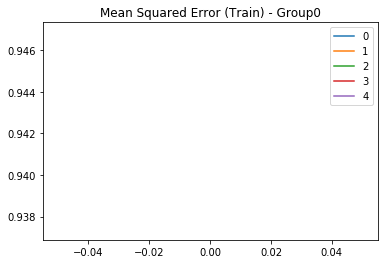

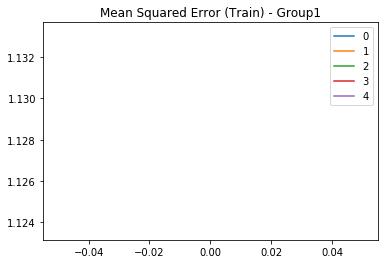

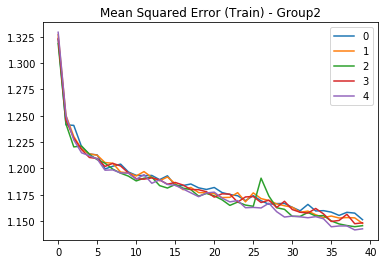

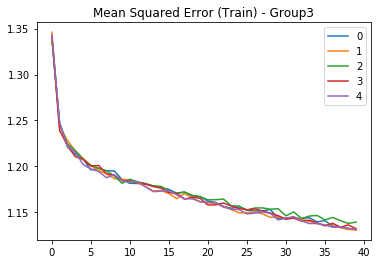

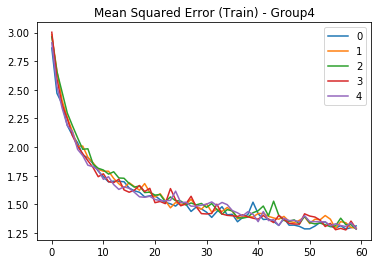

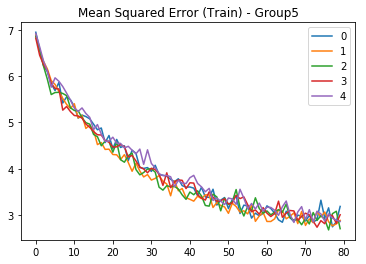

In [105]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group' + str(gp))
        plt.legend(); plt.show()        

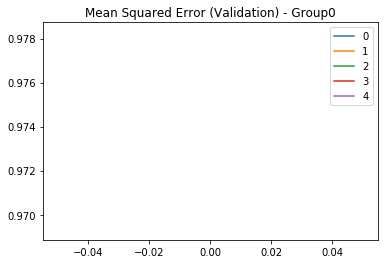

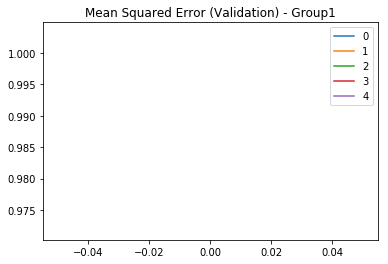

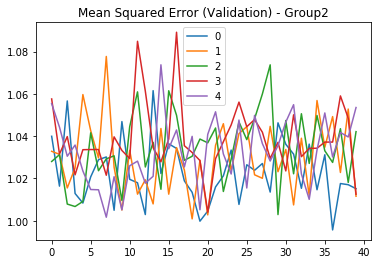

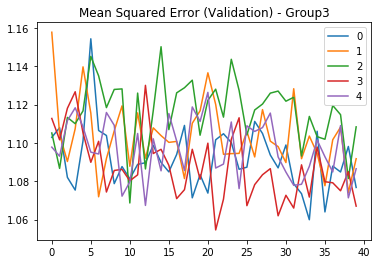

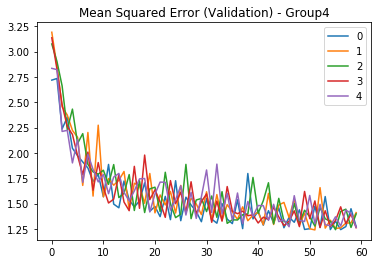

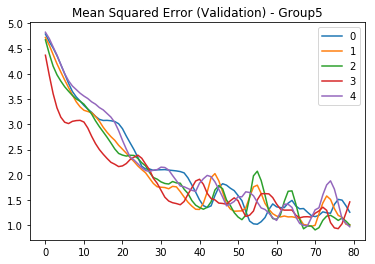

In [106]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group' + str(gp))
        plt.legend(); plt.show()        

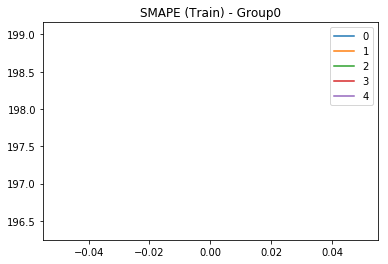

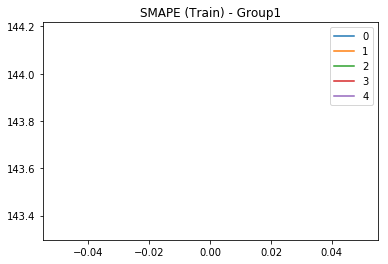

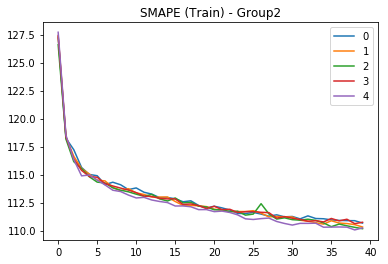

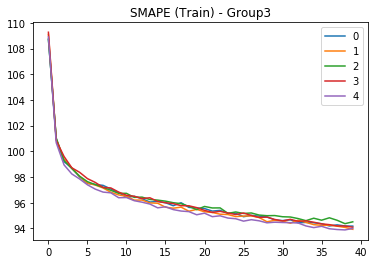

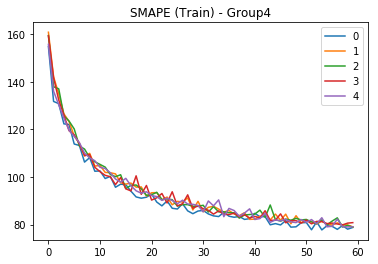

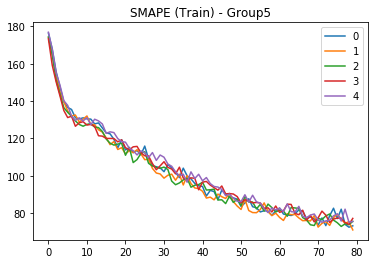

In [107]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group' + str(gp))
        plt.legend(); plt.show()        

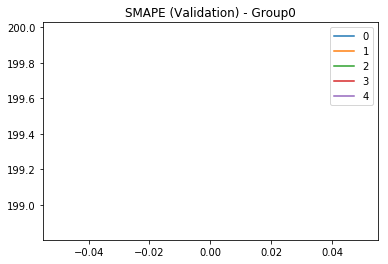

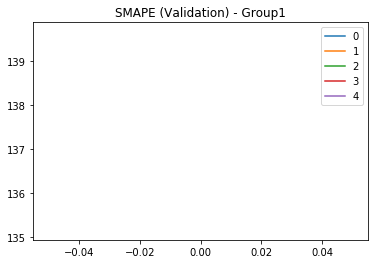

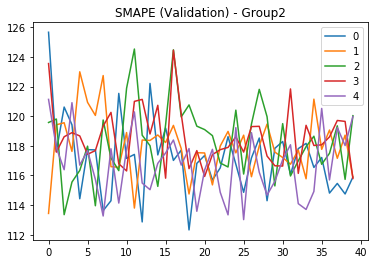

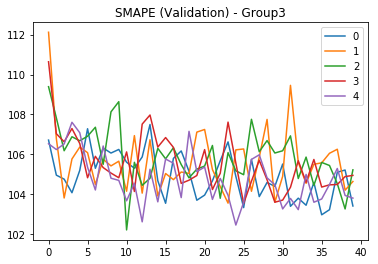

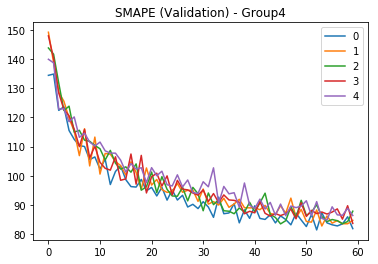

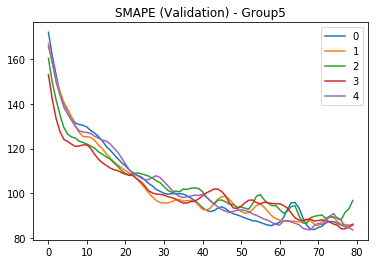

In [108]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group' + str(gp))
        plt.legend(); plt.show()        

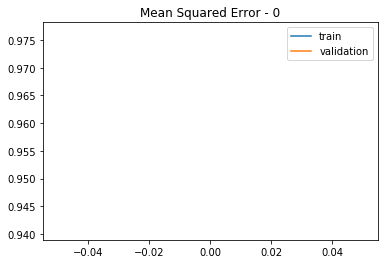

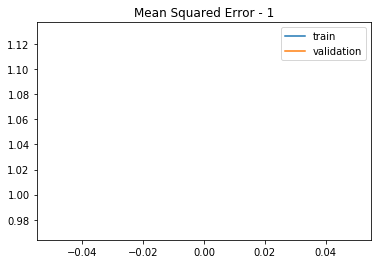

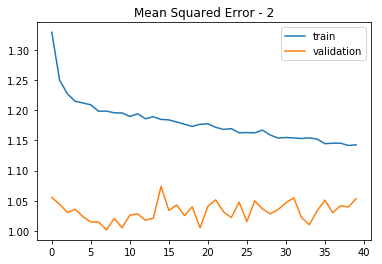

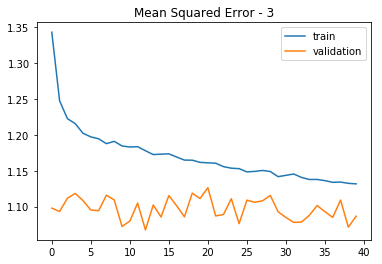

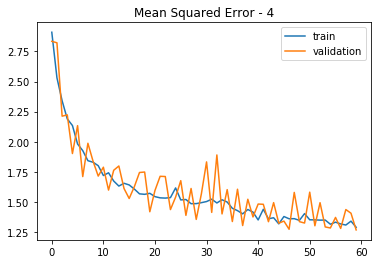

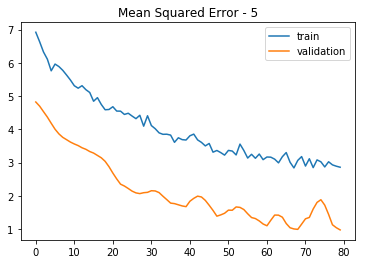

In [109]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

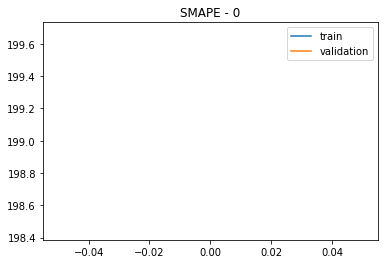

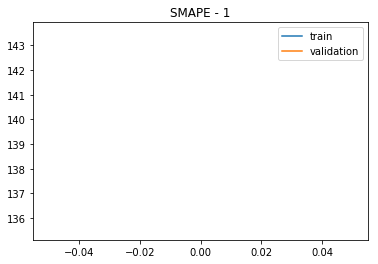

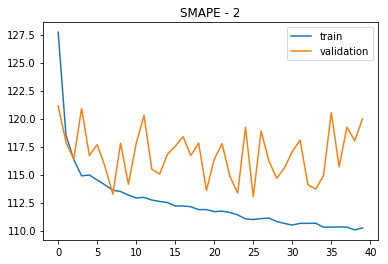

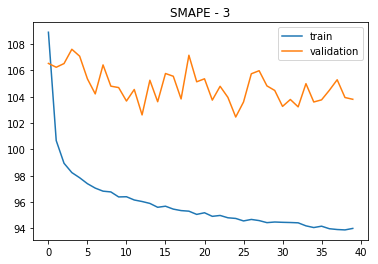

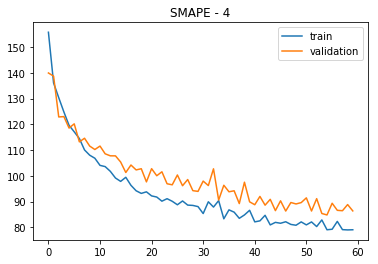

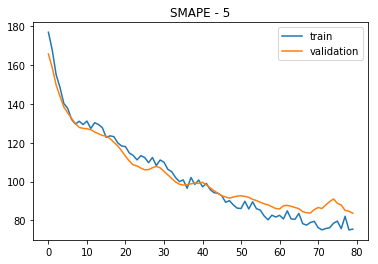

In [110]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

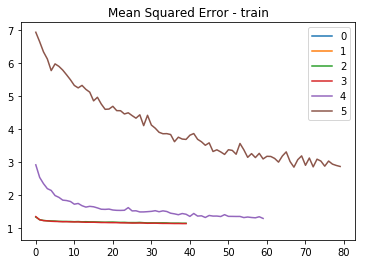

In [111]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

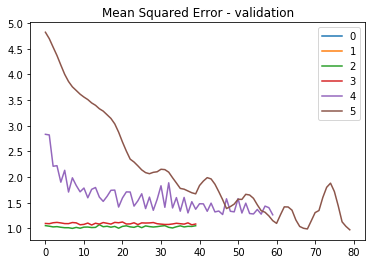

In [112]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

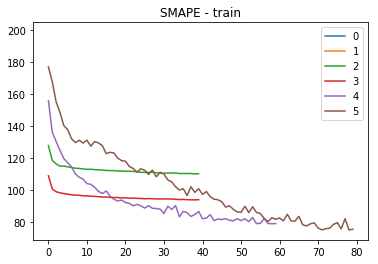

In [113]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

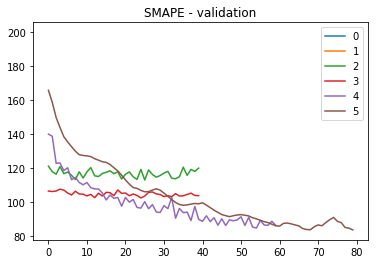

In [114]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using Output Set

if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))

### Predict for Output Set

In [116]:
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_output_list, A_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X,A]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 4 5 
Run 1: 0 1 2 3 4 5 
Run 2: 0 1 2 3 4 5 
Run 3: 0 1 2 3 4 5 
Run 4: 0 1 2 3 4 5 


Find the original index

In [117]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [118]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [119]:
for o in output_index_list:
    print(o.shape)

(1879,)
(23085,)
(43691,)
(75617,)
(740,)
(51,)


In [120]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([  1475,   3412,   3467, ..., 123025, 139119, 140151])

In [121]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred_temp = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred_temp[index] = y

    Y_output_pred = np.array(Y_output_pred_temp)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_temp

In [122]:
# Inverse transform Y of output

Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          output_center, output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

### Model Score

In [123]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        print(model_smape, model_smape_0)
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    print('-----------')
    print(model_smape_ens_mean, model_smape_0_ens_mean)

38.7819742672 42.1048932826
38.7975800896 42.4873573864
38.8004777012 42.6563200238
38.7982009591 42.4478964343
38.8994486564 42.5470035282
-----------
38.8155363347 42.4486941311


In [124]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

40.4041165988


### Group Scores
For self-testing stage only

In [125]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [126]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [127]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [128]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

if test_length: print(count_not_nan(Y_output_raw))

In [129]:
# Group SMAPE scores
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    #gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
    #              in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_output_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape, '%6.2f' % model_smape_0)

n_not_nan_gp

### Individual Page Scores

In [130]:
if test_length:
    smape_Y_pred_ens = []
    #smape_Y_pred_na = np.array([smape(yp, y) for yp, y 
    #                            in zip(Y_output_pred_ori, Y_output_raw)])
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


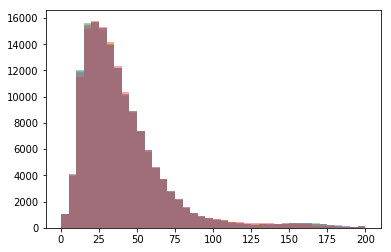

In [131]:
if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.show()

### SMAPE for the Model

In [132]:
if test_length:
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

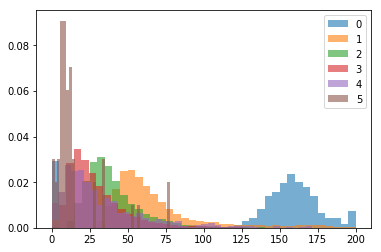

In [133]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.legend()
    plt.show()

if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

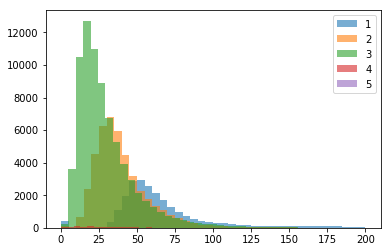

In [134]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

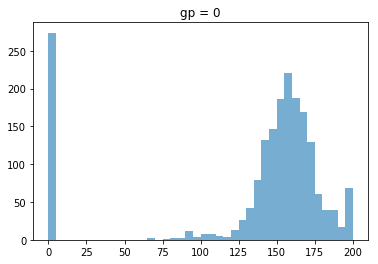

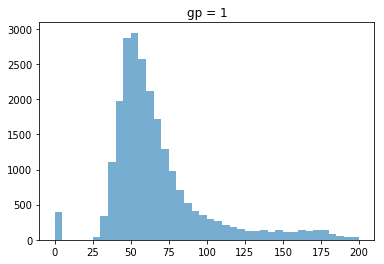

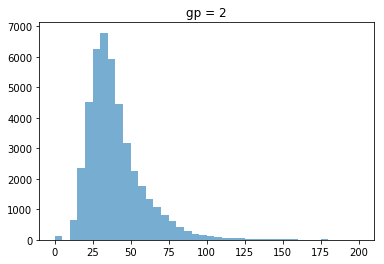

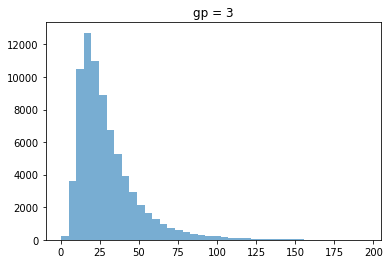

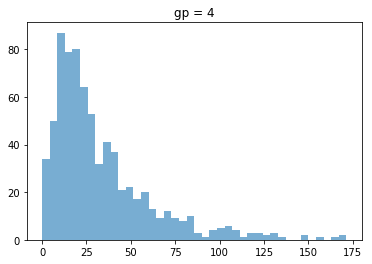

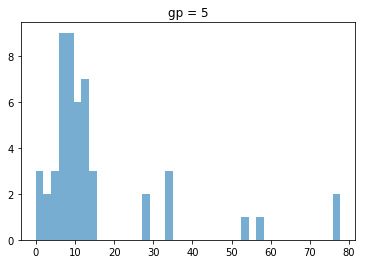

In [135]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

### SMAPE for Fibonacci median

In [136]:
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [137]:
# Group SMAPE for Fib.
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [138]:
# Individual SMAPE for Fib.
if test_length:
    #smape_Y_fib_na = np.array([smape(yp, y) for yp, y 
    #                           in zip(Y_output_fib, Y_output_raw)])
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]
# The above two cells can be combined.

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


#### SMAPE distribution for Fib

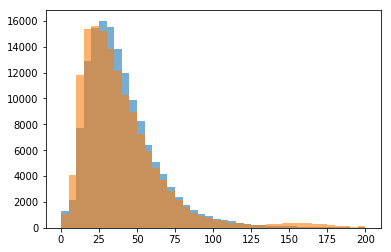

In [139]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6)
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

if test_length:
    for i,s in zip(range(len(smape_Y_fib_list[1:])),smape_Y_fib_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

if test_length:
    for i in range(len(smape_Y_fib_list)):
        plt.hist(smape_Y_pred_list[i], bins=40, alpha=0.7, label='Model')
        plt.hist(smape_Y_fib_list[i], bins=40, alpha=0.5, label='Fib')
        plt.title('gp = '+str(i))
        plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

### Models vs Fibonacci Median

if test_length:  # gp_score
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')

#### model_10_Modified_CNN_0_median_stdev
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

## Prediction Combine
Combine group 0, 1 from Fib and rest from the model

In [142]:
Y_output_fib.shape

(145063, 1)

In [143]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [144]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [145]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

In [146]:
Y_output_fmc_ori

array([[ 28.01709045,  27.8863257 ,  28.29876437, ...,  25.76354474,
         25.29633754,  25.94749649],
       [ 23.29458711,  24.05617622,  24.41074557, ...,  22.20339414,
         21.58530887,  22.52307853],
       [  4.        ,   4.        ,   4.        , ...,   4.        ,
          4.        ,   4.        ],
       ..., 
       [ 29.03831963,  30.79668599,  31.41995859, ...,  29.30488701,
         28.14239607,  29.94105893],
       [  7.75      ,   7.75      ,   7.75      , ...,   7.75      ,
          7.75      ,   7.75      ],
       [ 12.77091126,  10.78378789,  11.5977682 , ...,  13.85813817,
         13.36614969,  14.72259607]])

In [147]:
model_smape_ens

[38.781974267207353,
 38.797580089618442,
 38.800477701161888,
 38.798200959063713,
 38.899448656374084]

In [148]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [149]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

37.583 (38.782) - model_10_Modified_CNN_0_median_stdev 0
37.652 (38.798) - model_10_Modified_CNN_0_median_stdev 1
37.626 (38.800) - model_10_Modified_CNN_0_median_stdev 2
37.818 (38.798) - model_10_Modified_CNN_0_median_stdev 3
37.754 (38.899) - model_10_Modified_CNN_0_median_stdev 4
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average


#### Combined Scores:
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## Ensemble Learning

In [ ]:
Y_output_pred_ori_ens

### Method 1 - Mean

In [150]:
Y_output_pred_ori_ens_mean = np.mean(Y_output_pred_ori_ens, axis=0)

In [151]:
Y_output_pred_ori_ens_mean.shape

(145063, 63)

Y_output_pred_ori_ens_mean

In [152]:
smape(Y_output_pred_ori_ens_mean, Y_output_raw)

38.869025831837448

### Method 2 - Median

In [153]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)

In [154]:
Y_output_pred_ori_ens_med.shape

(145063, 63)

Y_output_pred_ori_ens_med

In [155]:
smape(Y_output_pred_ori_ens_med, Y_output_raw)

38.620586961564996

### Method 3 - Mean before inverse transform and log

In [156]:
Y_output_pred_ens_mean = np.mean(Y_output_pred_ens, axis=0)
Y_output_pred_ens_mean_ori = unlog(untransform(Y_output_pred_ens_mean, output_center, output_scale))

In [157]:
smape(Y_output_pred_ens_mean_ori, Y_output_raw)

38.769464925281838

### Method 4 - Median before inverse transform and log

In [158]:
Y_output_pred_ens_med = np.median(Y_output_pred_ens, axis=0)
Y_output_pred_ens_med_ori = unlog(untransform(Y_output_pred_ens_med, output_center, output_scale))

In [159]:
smape(Y_output_pred_ens_med_ori, Y_output_raw)

38.620586961564996

Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

In [160]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [161]:
# The combined result

Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
Y_output_pred_ens_med_ori

array([[ 24.31284783,  24.80548325,  25.18046906, ...,  24.27431746,
         23.81172835,  24.4367356 ],
       [ 26.02571694,  26.20181696,  26.77890944, ...,  23.18114653,
         22.55339728,  23.24782331],
       [  3.44014823,   3.68366573,   3.36283533, ...,   3.29010504,
          3.3687697 ,   3.61722868],
       ..., 
       [ 30.47952252,  32.15962137,  33.03829822, ...,  31.13491518,
         30.00493242,  31.49540946],
       [  6.95438656,   7.22314889,   6.83119515, ...,   6.8742709 ,
          6.7118889 ,   7.21505335],
       [  8.05731149,   7.54166947,   7.73842967, ...,   9.363081  ,
          8.98574088,   9.92741165]])

In [162]:
Y_output_f_omean = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_mean
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med
Y_output_f_meano = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_mean_ori
Y_output_f_medo  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_med_ori

In [163]:
if test_length:
    f_omean_smape = smape(Y_output_raw, Y_output_f_omean)
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)
    f_meano_smape = smape(Y_output_raw, Y_output_f_meano)
    f_medo_smape = smape(Y_output_raw, Y_output_f_medo)

In [164]:
if test_length: # The_score
    print('%6.3f         ' % f_omean_smape, '-', model_name, 'ori_ens_mean')
    print('%6.3f         ' % f_omed_smape, '-', model_name, 'ori_ens_med')
    print('%6.3f         ' % f_meano_smape, '-', model_name, 'ens_mean_ori')
    print('%6.3f         ' % f_medo_smape, '-', model_name, 'ens_med_ori')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

37.436          - model_10_Modified_CNN_0_median_stdev ori_ens_mean
37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med
37.394          - model_10_Modified_CNN_0_median_stdev ens_mean_ori
37.382          - model_10_Modified_CNN_0_median_stdev ens_med_ori
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average


In [165]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

37.583 (38.782) - model_10_Modified_CNN_0_median_stdev 0
37.652 (38.798) - model_10_Modified_CNN_0_median_stdev 1
37.626 (38.800) - model_10_Modified_CNN_0_median_stdev 2
37.818 (38.798) - model_10_Modified_CNN_0_median_stdev 3
37.754 (38.899) - model_10_Modified_CNN_0_median_stdev 4
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average


Ensemble of model are all better than the individual model.

In [166]:
fmc_smape_ens

[37.582776576881216,
 37.652157945887168,
 37.625518077549707,
 37.81823438931761,
 37.754247776116046]

In [167]:
fmc_smape_ens_mean

37.686586953150353

 Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

### All Group Scores

In [168]:
# ensemble result Y_output in each group
Y_output_pred_ori_ens_mean_list = [Y_output_pred_ori_ens_mean[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_ens_med_list = [Y_output_pred_ori_ens_med[output_gp == gp] for gp in gp_list]
Y_output_pred_ens_mean_ori_list = [Y_output_pred_ens_mean_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ens_med_ori_list = [Y_output_pred_ens_med_ori[output_gp == gp] for gp in gp_list]

In [169]:
# Group SMAPE scores
if test_length:
    # SMAPE with nan values ignored (used by Kaggle)
    gp_omean_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_mean_list)]
    gp_omed_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_med_list)]
    gp_meano_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ens_mean_ori_list)]
    gp_medo_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ens_med_ori_list)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [170]:
if test_length:  # The_gp_score
    print('#### ' + model_name)
    print('', end='|')
    print(' N_pages', 'Fibonacci', ' ori mean', 'ori media', ' mean ori', 'media ori', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_omean_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_meano_smape[gp], end='|')
        print(' %7.3f ' % gp_medo_smape[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')

#### model_10_Modified_CNN_0_median_stdev
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.741 | 172.496 | 191.624 | 172.496 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.110 |  64.122 |  64.116 |  64.122 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.620 |  39.564 |  39.574 |  39.564 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.300 |  29.231 |  29.248 |  29.231 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.403 |  33.482 |  33.373 |  33.482 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.360 |  16.338 |  16.361 |  16.338 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |


#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.921 | 173.799 | 189.346 | 173.799 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  63.635 |  63.651 |  63.644 |  63.651 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  39.693 |  39.628 |  39.637 |  39.628 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  29.444 |  29.368 |  29.381 |  29.368 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.858 |  33.893 |  33.837 |  33.893 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.861 |  16.948 |  16.856 |  16.948 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

### Plots

In [171]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]; view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

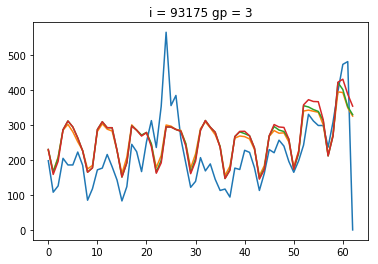

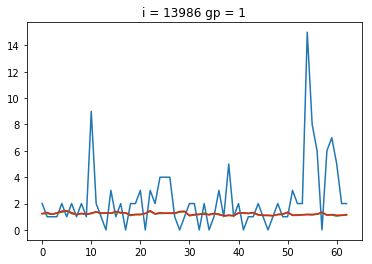

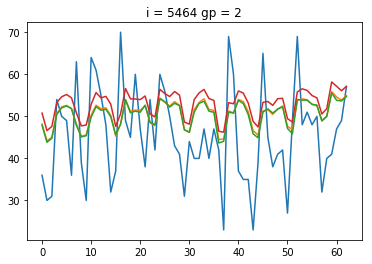

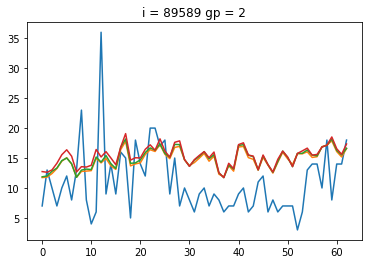

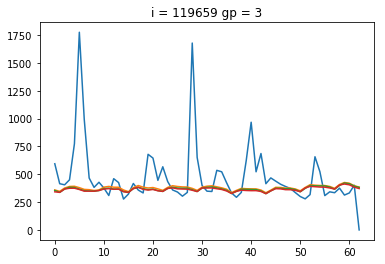

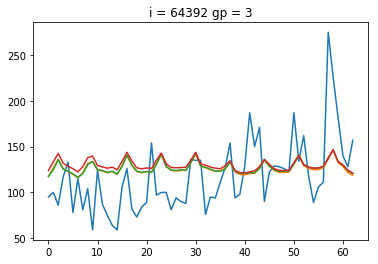

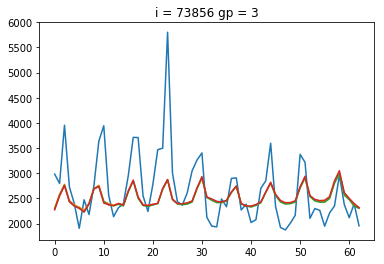

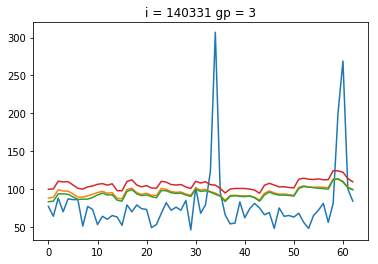

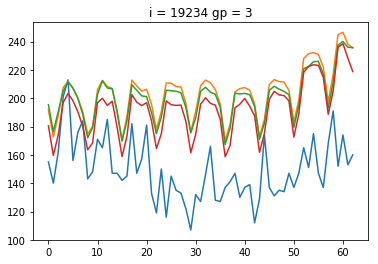

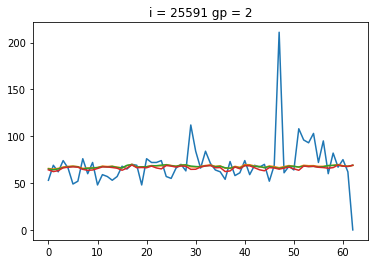

In [172]:
view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

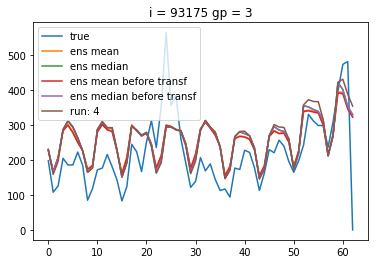

In [173]:
i = 93175
plt.plot(Y_output_ori[i], label='true')
plt.plot(Y_output_pred_ori_ens_mean[i], label='ens mean')
plt.plot(Y_output_pred_ori_ens_med[i], label='ens median')
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.plot(Y_output_pred_ens_med_ori[i], label='ens median before transf')
plt.plot(Y_output_pred_ori_ens[-1][i], label='run: 4')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

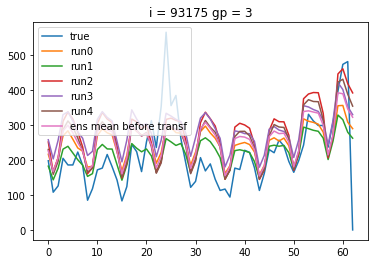

In [174]:
i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

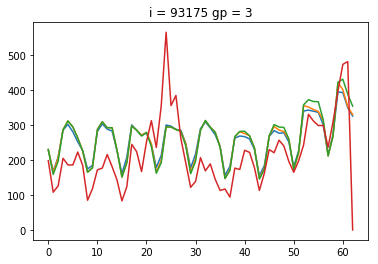

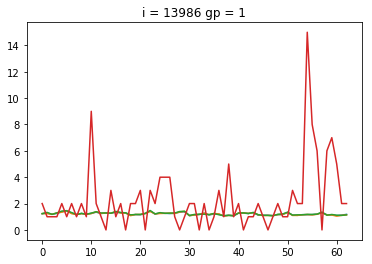

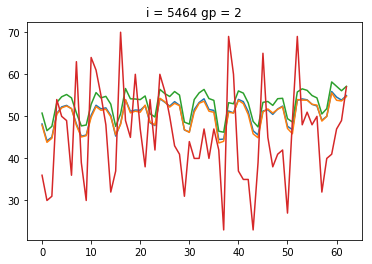

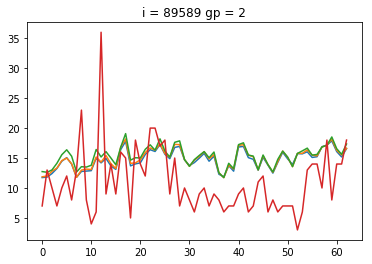

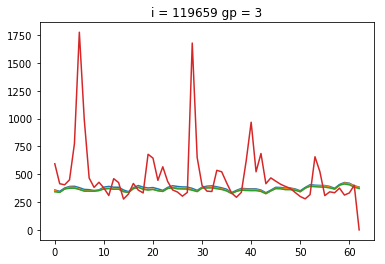

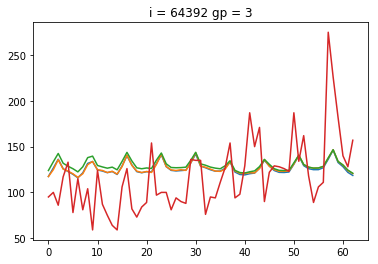

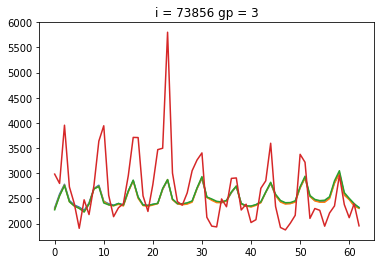

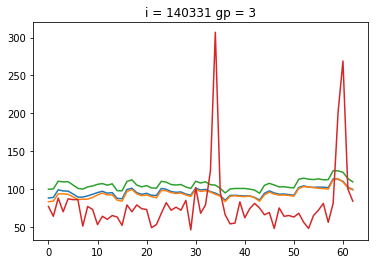

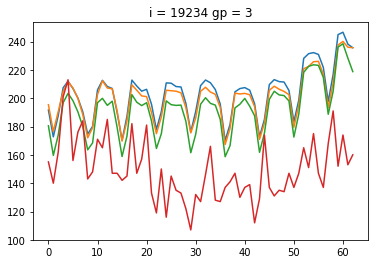

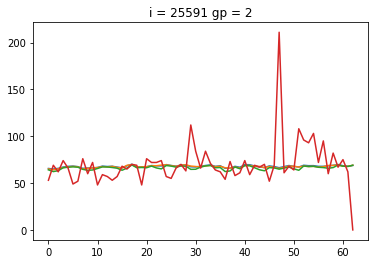

In [175]:
view_list = examine_list_gp((Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             Y_output_ori), output_gp, view_list=view_list)

## Case Study

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [176]:
view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

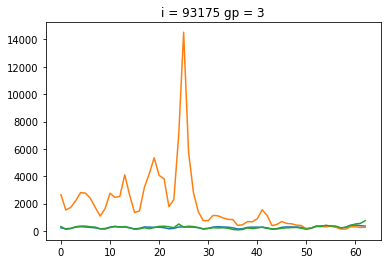

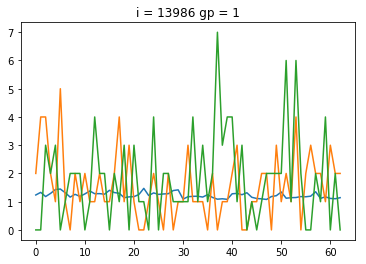

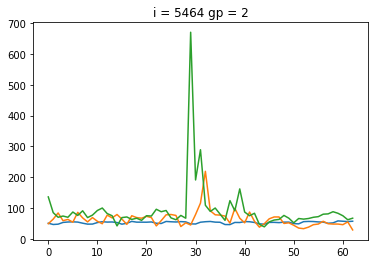

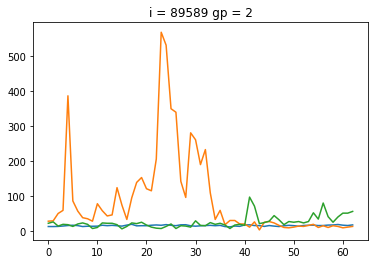

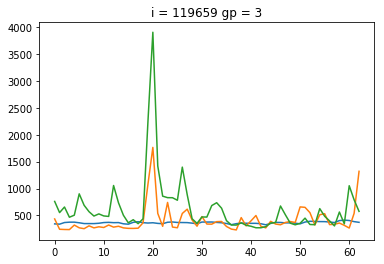

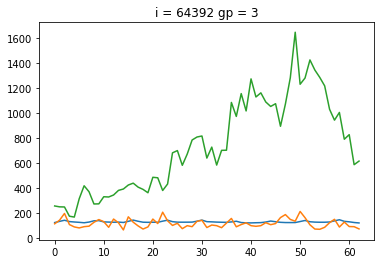

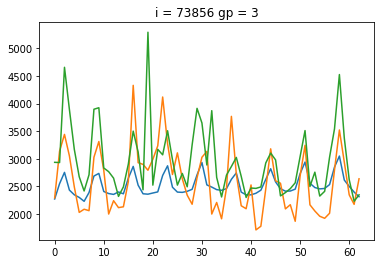

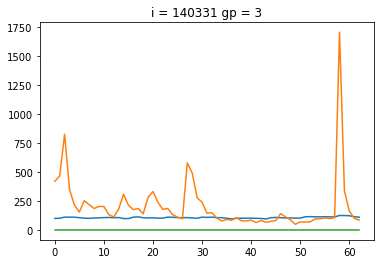

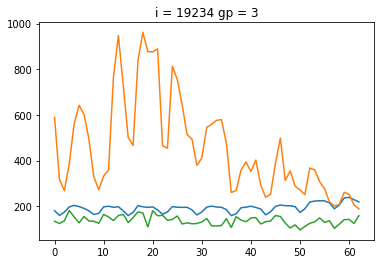

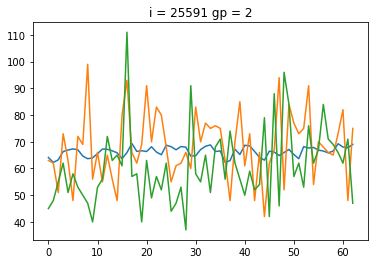

In [177]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

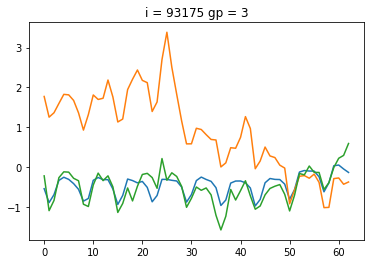

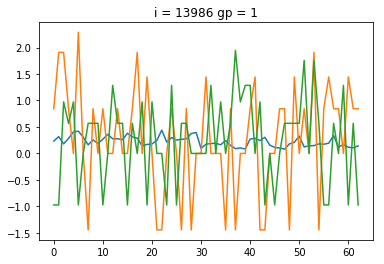

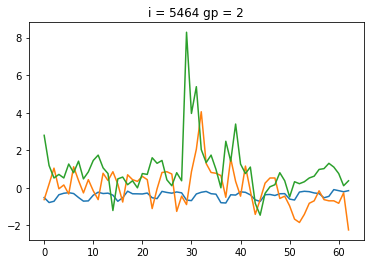

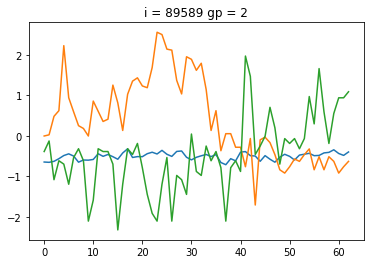

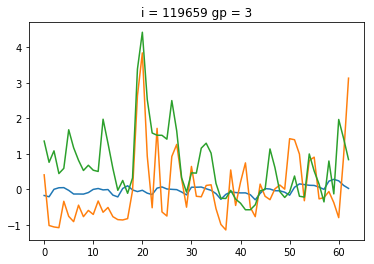

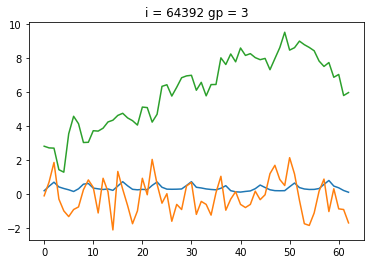

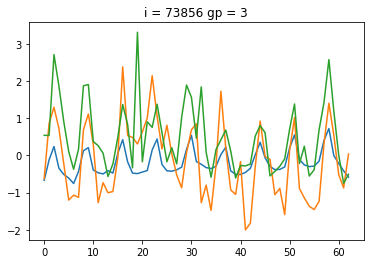

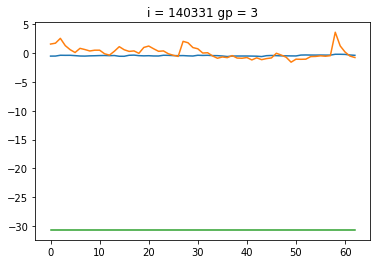

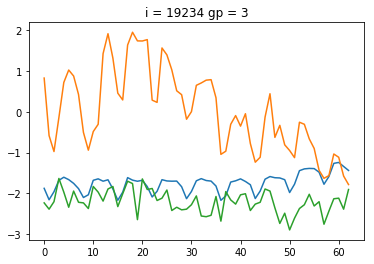

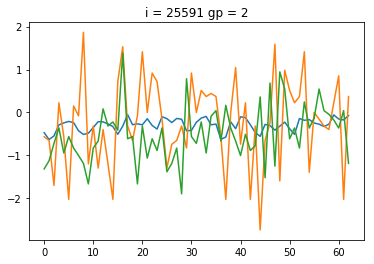

In [178]:
view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

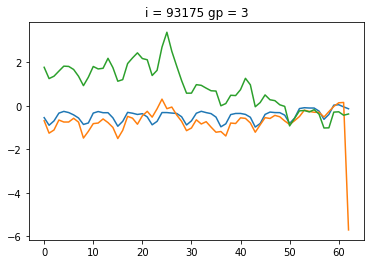

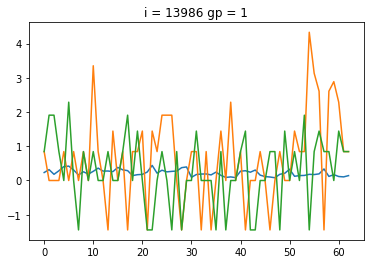

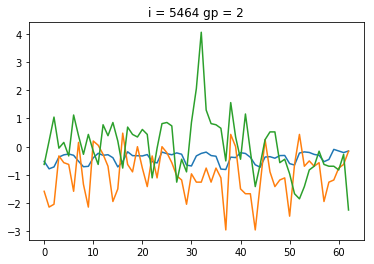

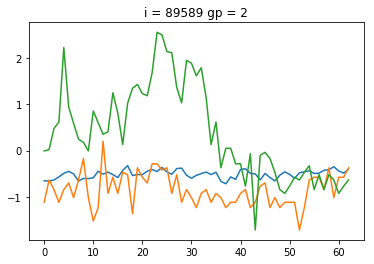

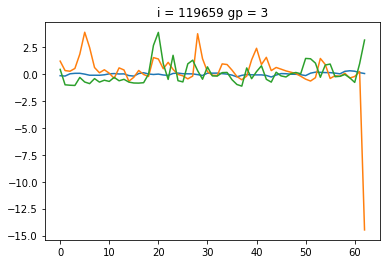

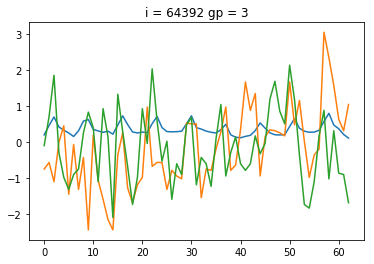

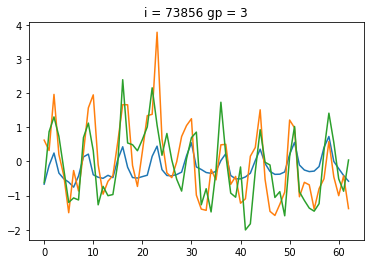

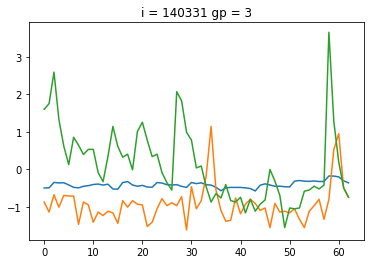

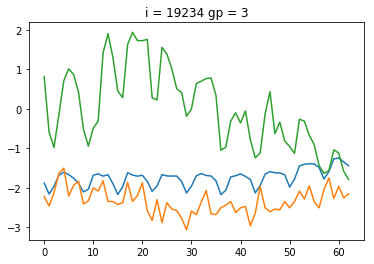

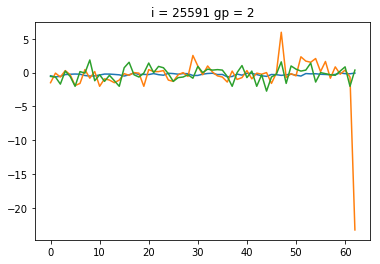

In [179]:
if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

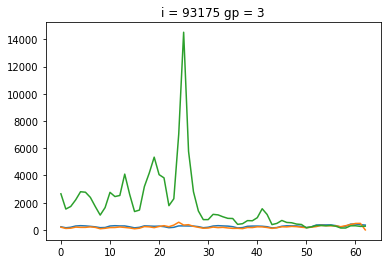

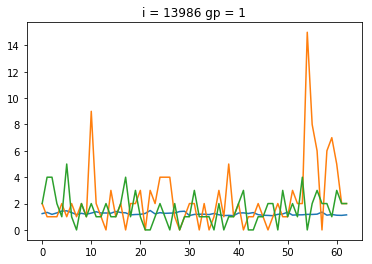

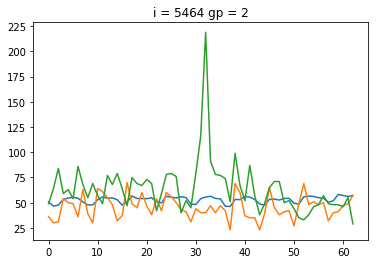

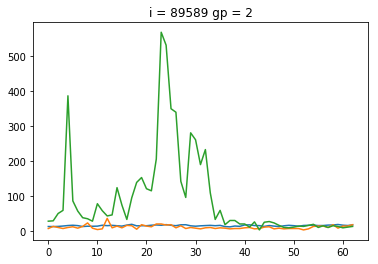

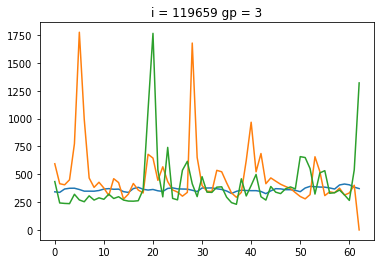

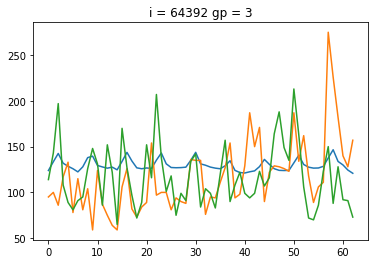

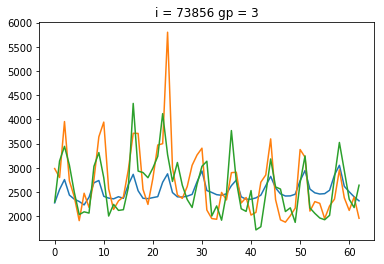

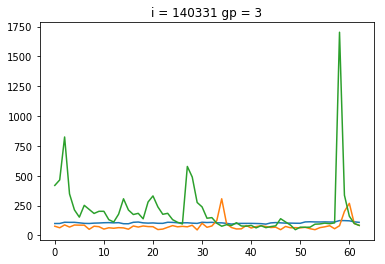

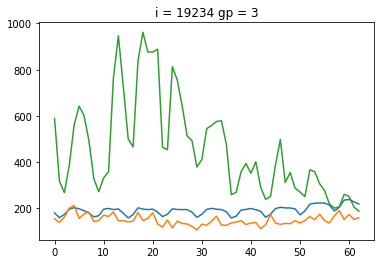

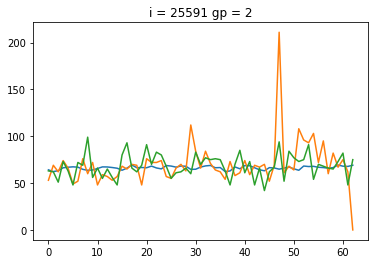

In [180]:
if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

In [181]:
view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

[31.324016453516229,
 79.476734413499045,
 23.957087168459996,
 47.736318643175323,
 28.076116489024809,
 26.874541947896319,
 15.333611475669059,
 42.302686848871787,
 25.773616444585695,
 15.716168107014544]

In [182]:
view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

[True, False, True, False, True, True, True, False, True, True]

In [183]:
view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

[93175, 5464, 119659, 64392, 73856, 19234, 25591]

In [184]:
view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

[13986, 89589, 140331]

#### Good cases

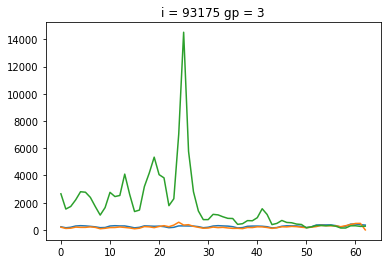

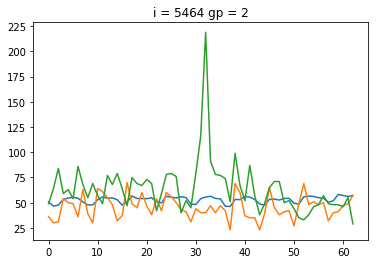

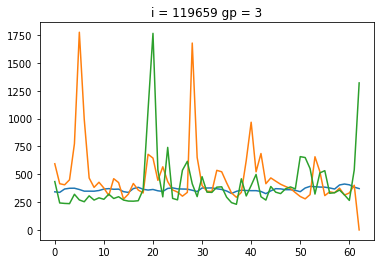

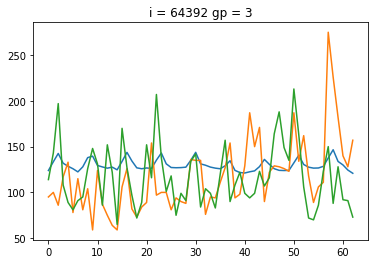

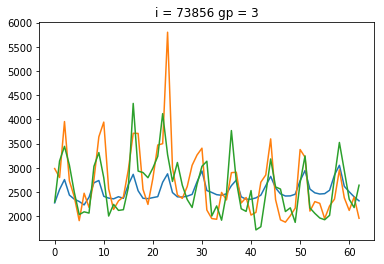

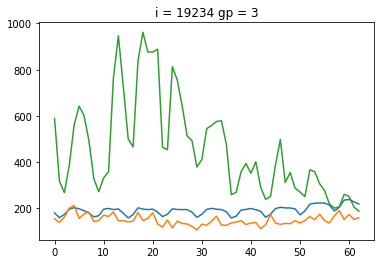

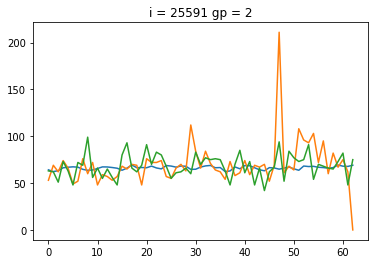

[93175, 5464, 119659, 64392, 73856, 19234, 25591]

In [185]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

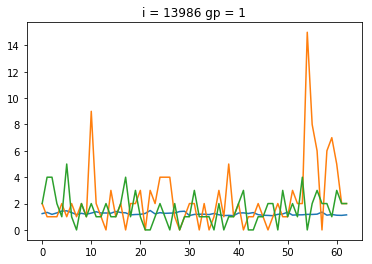

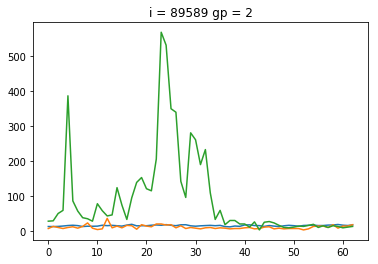

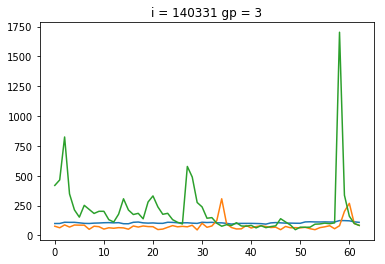

[13986, 89589, 140331]

In [186]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

In [187]:
print(output_center[view_list_good].reshape(-1))
print(output_center[view_list_bad].reshape(-1))

[ 2.61225391  1.78532984  2.56555268  2.07280115  3.41796964  2.61489722
  1.85125835]
[ 0.30103     1.46612587  2.14921911]


In [188]:
print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

[ 0.45758495  0.13744919  0.17725717  0.12048413  0.09144428  0.18993217
  0.07964336]
[ 0.20849044  0.50503777  0.29619523]


In [189]:
output_gp[view_list_good]

array([3, 2, 3, 3, 3, 3, 2])

In [190]:
output_gp[view_list_bad]

array([1, 2, 3])

#### Case 93175

In [193]:
i = 93175

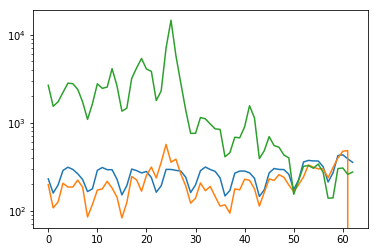

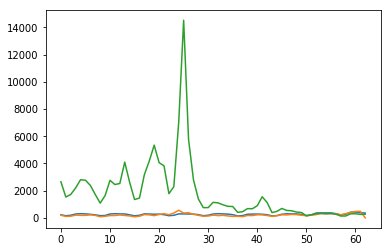

In [194]:
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

In [195]:
smape(Y_output_pred_ori[i], Y_output_raw[i])

31.324016453516229

In [196]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 2.61225391]),
 array([ 2.61225391]),
 array([ 0.4493528]),
 array([ 0.45758495]))

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

In [197]:
review_Y = np.array([score < model_smape for score in smape_Y_pred])
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; #good_Y_index
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; #bad_Y_index

In [201]:
good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

In [202]:
good_input_center = input_center[good_Y_index]
good_output_center = output_center[good_Y_index]
bad_input_center = input_center[bad_Y_index]
bad_output_center = output_center[bad_Y_index]

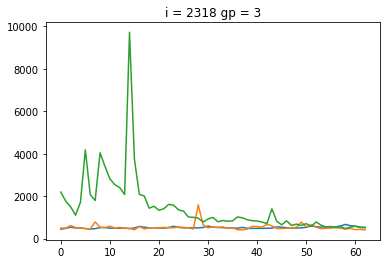

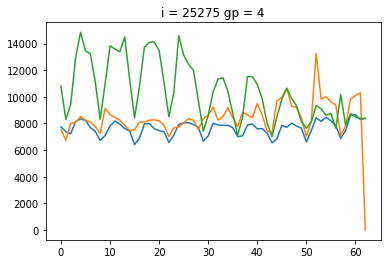

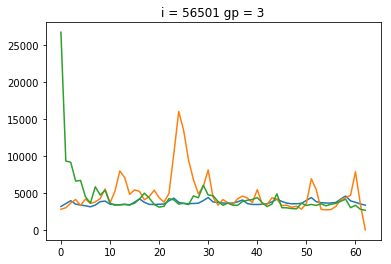

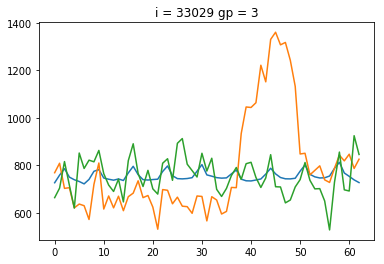

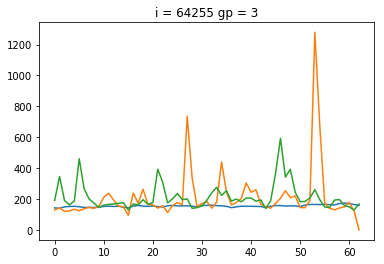

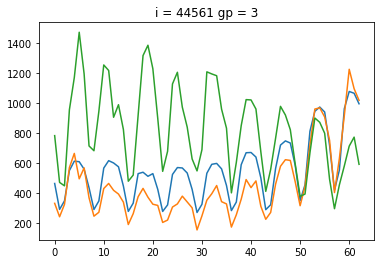

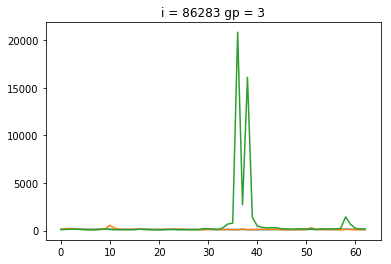

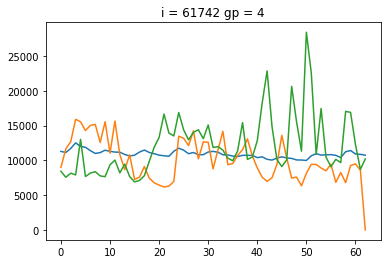

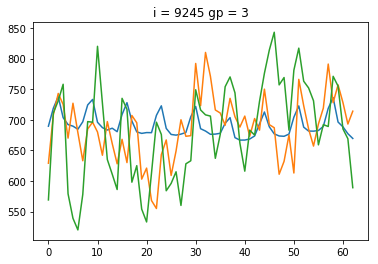

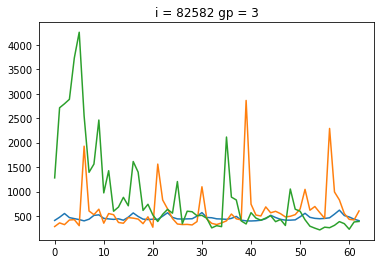

[2318, 25275, 56501, 33029, 64255, 44561, 86283, 61742, 9245, 82582]

In [205]:
examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

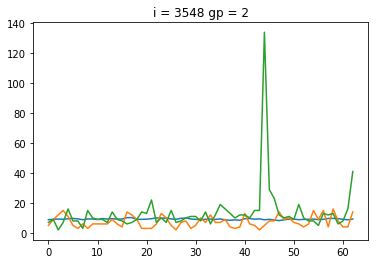

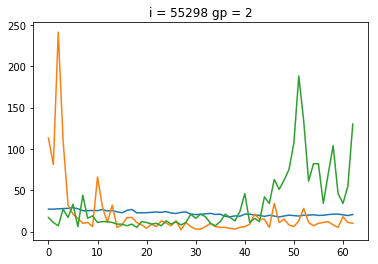

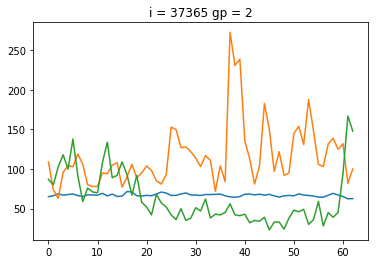

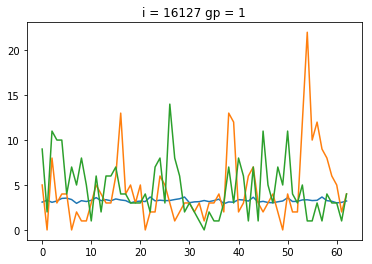

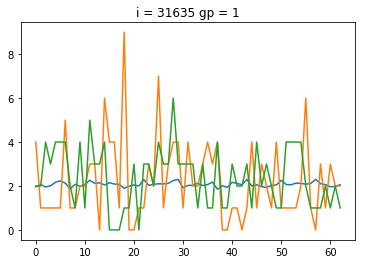

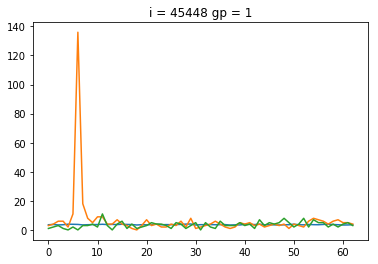

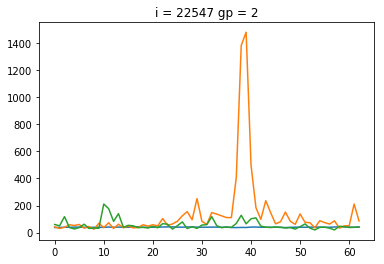

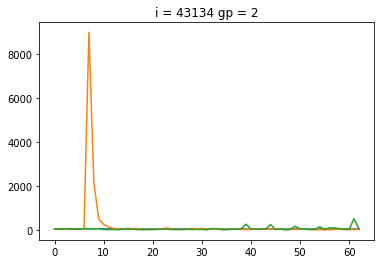

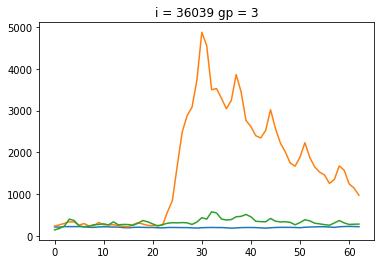

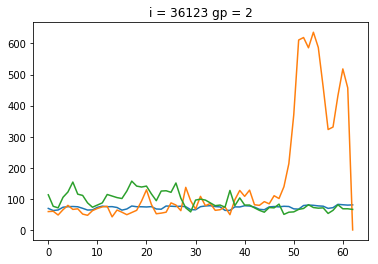

[3548, 55298, 37365, 16127, 31635, 45448, 22547, 43134, 36039, 36123]

In [206]:
examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

In [207]:
good_output_scale.min(), good_output_scale.max()

(0.0053654329977268714, 1.3484600516008696)

In [208]:
bad_output_scale.min(), bad_output_scale.max()

(0.0016980961003407436, 2.0382773961171501)

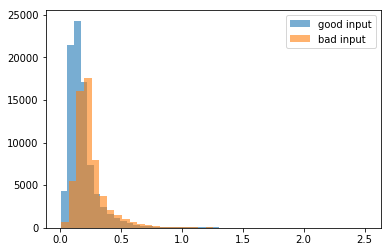

In [209]:
plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

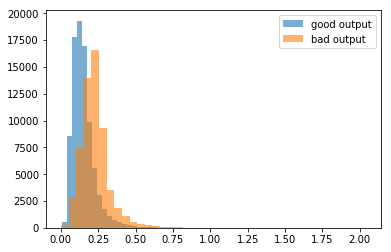

In [210]:
plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

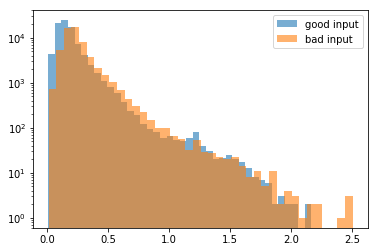

In [211]:
plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

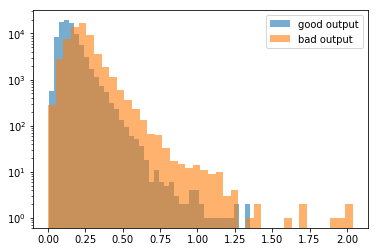

In [212]:
plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

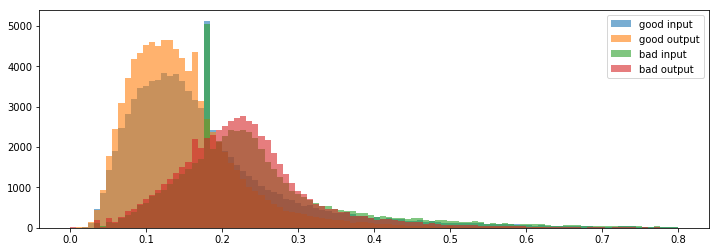

In [213]:
plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

In [214]:
np.mean(good_output_scale), np.mean(good_input_scale)

(0.14823512183053353, 0.18748276181141144)

In [215]:
np.mean(bad_output_scale), np.mean(bad_input_scale)

(0.22998480893524639, 0.25785562296572406)

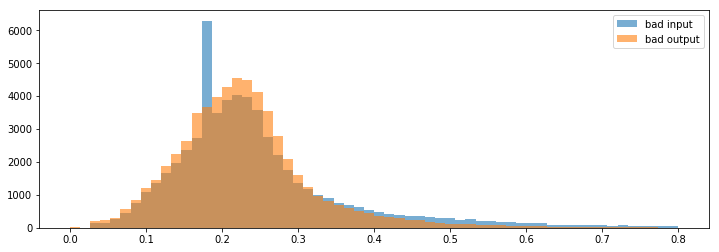

In [216]:
plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

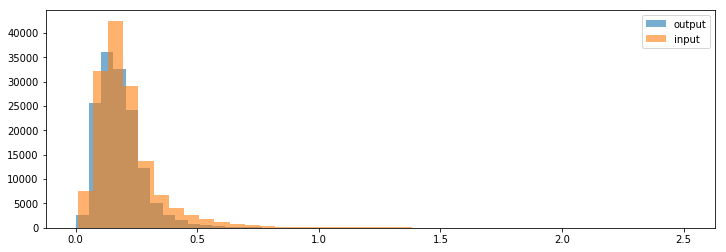

In [217]:
plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

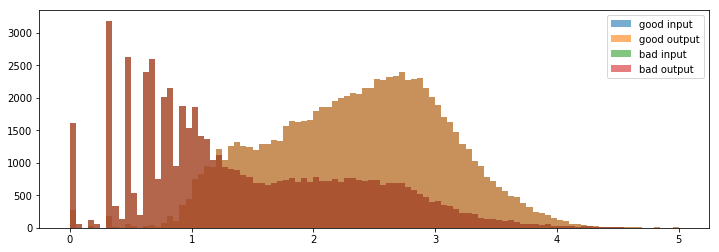

In [218]:
plt.figure(figsize=(12,4))
plt.hist(good_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

In [219]:
gc.collect()

69660

### stdev/median

output_factor_1 = (output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [ ]:
Y_output_dates

In [ ]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_f_omed, columns = Y_output_dates)  # using ensemble median combined result
result_df

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]